### Setting up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile  # comment for hpc
import os, tarfile
from pathlib import Path

from transformers import SamProcessor, SamConfig
from PIL import Image

import torch
from torch.utils.data import IterableDataset, DataLoader

import cv2
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import nearest_points
from centerline.geometry import Centerline
import geopandas as gpd
import rasterio.features

# paths, feel free to change it to suit your needs
dataset_path = Path()
# for extracting tar in hpc
# dataset_path = Path().absolute().joinpath("shared", "mldatasets", "sidewalks")

test_label_path = dataset_path.joinpath("Label", "Test")
test_images_path = dataset_path.joinpath("Test")
train_label_path = dataset_path.joinpath("Label", "Train")
train_images_path = dataset_path.joinpath("Train")

2024-05-04 17:35:42.191206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 17:35:43.057720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def read_dir(path):
    '''to read files from local file system on the path, used initially when I was training the model in my local machine'''

    for file_name in os.listdir(str(path)):
        if file_name.endswith(".tfw") or file_name == "yolact":
            continue
        image = tifffile.imread(str(path.joinpath(file_name)))
        yield image


def read_tar(tar, directory):
    '''generator to read image in the specified directory in the provided tarfile object'''
    for file in tar:
        if file.path.startswith(directory):
            file_name = file.path.split("/")[-1]
            if file_name.endswith(".tfw") or file_name == "yolact":
                continue
            c = tar.extractfile(file).read()
            na = np.frombuffer(c, dtype=np.uint8)
            im = cv2.imdecode(na, cv2.IMREAD_COLOR)
            yield im


class SAMDataset(IterableDataset):
    """ copied from tutorial!
    We need to use generators instead of naively storing all data in memory due to the sheer size of the training data.
    """

    def __init__(self, path_x, path_y, processor, is_tar=False, dirx=None, diry=None):  # x: input, y: label
        self.processor = processor
        if is_tar:  # read tar, path=path to tar file; dirx, diry=folders to read inside the tar file
            self.generator_x = read_tar(tarfile.open(str(path_x), "r:*"), dirx)
            self.generator_y = read_tar(tarfile.open(str(path_y), "r:*"), diry)
        else:
            self.generator_x = read_dir(path_x)
            self.generator_y = read_dir(path_y)

    def __iter__(self):  # copied from tutorial
        for image, ground_truth_mask in zip(self.generator_x, self.generator_y):
            # get bounding box prompt (uninformative)
            # H, W, _ = ground_truth_mask.shape #HPC
            H, W = ground_truth_mask.shape  # local
            prompt = [0, 0, W, H]
            # prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
            # remove batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            # add ground truth segmentation
            inputs["ground_truth_mask"] = ground_truth_mask
            yield inputs, image

In [3]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")  # preprocess
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")

sidewalk_model = torch.load('sam-base-sidewalk.pth')


### Plot 10 sidewalk images that are affected by occlusion problem

In [4]:
def plot_batch(selected_batch, image, subplots=4):
    sidewalk_model.eval()

    # forward pass
    with torch.no_grad():
        outputs = sidewalk_model(pixel_values=selected_batch["pixel_values"].to(device),
                                 input_boxes=selected_batch["input_boxes"].to(device),
                                 multimask_output=True)

    # apply sigmoid
    seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # convert soft mask to hard mask
    seg_prob = seg_prob.cpu().numpy().squeeze().transpose(1, 2, 0)
    seg_prob = cv2.cvtColor(seg_prob, cv2.COLOR_RGB2GRAY)

    seg = (seg_prob > 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, subplots, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(image.squeeze(0))
    axes[0].set_title("Image")

    # Plot the second image on the right
    axes[1].imshow(seg.astype(float))
    axes[1].set_title("Mask")

    # Plot the second image on the right
    axes[2].imshow(seg_prob, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Probability Map")

    axes[3].imshow(np.squeeze(selected_batch["ground_truth_mask"]), cmap='gray')
    axes[3].set_title("Ground Truth Mask")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

In [73]:
# HPC load from tar
# testset = SAMDataset(str(dataset_path.joinpath("val.tar")), str(dataset_path.joinpath("label.tar")), processor, True,
#                      "Test/", "Label/Test/")
# local load from folder
testset = SAMDataset(test_images_path, test_label_path, processor)
testloader = DataLoader(testset, batch_size=1)
device = 'cuda'

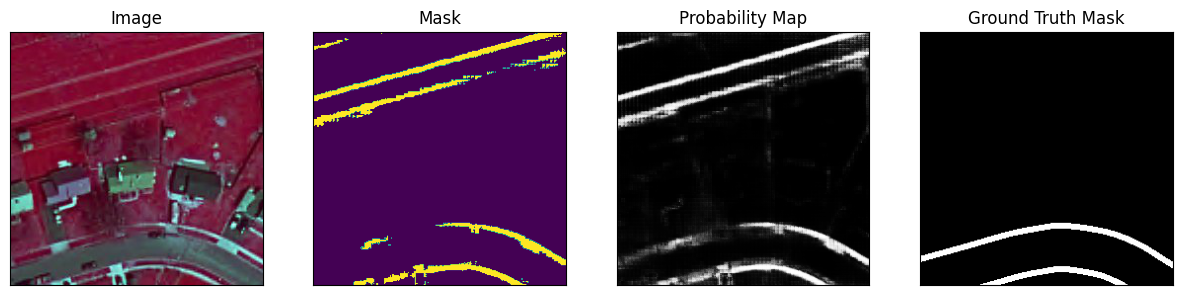

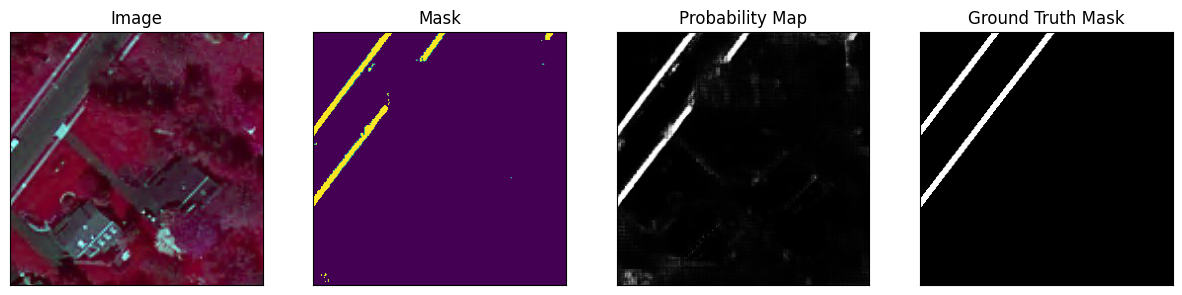

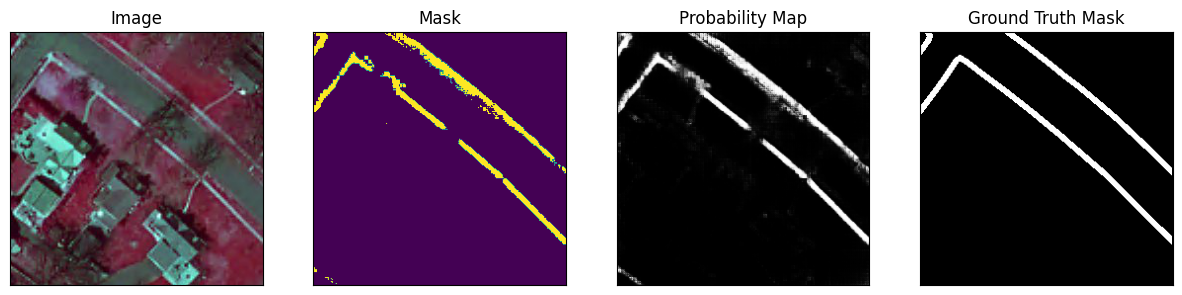

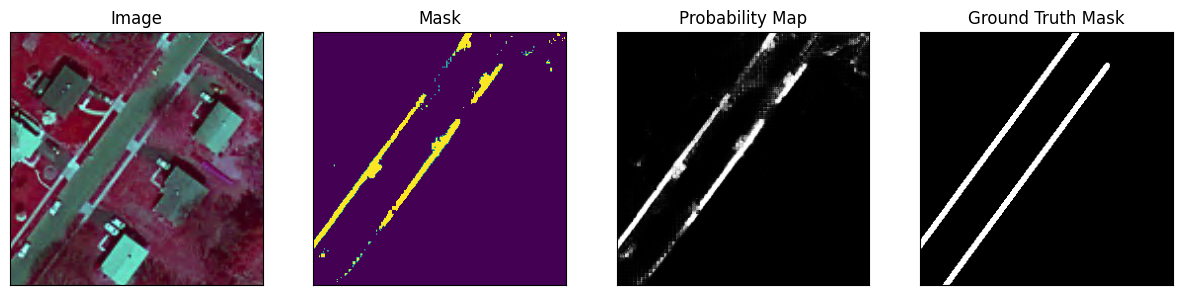

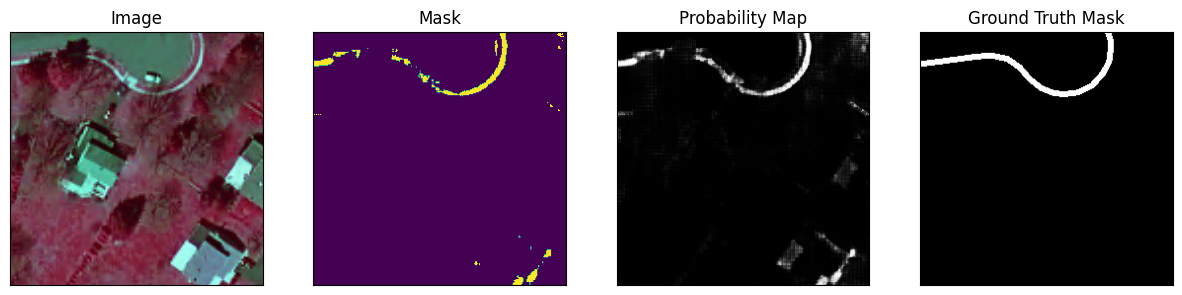

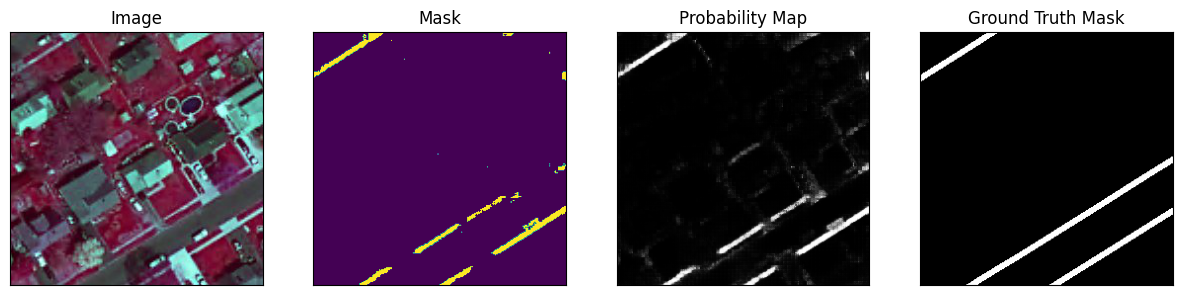

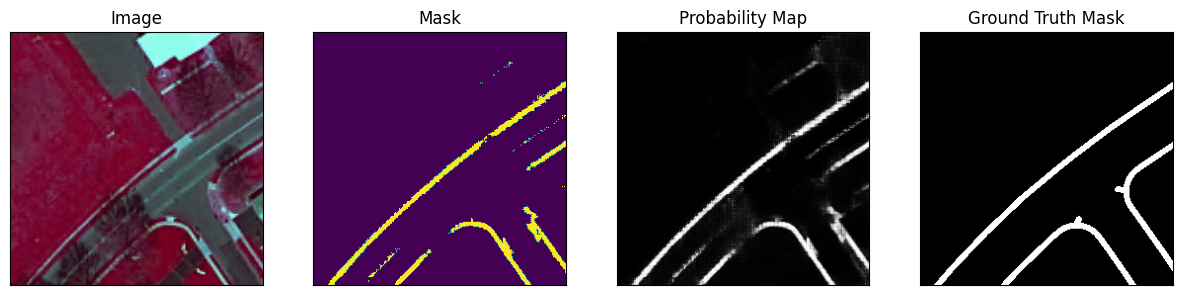

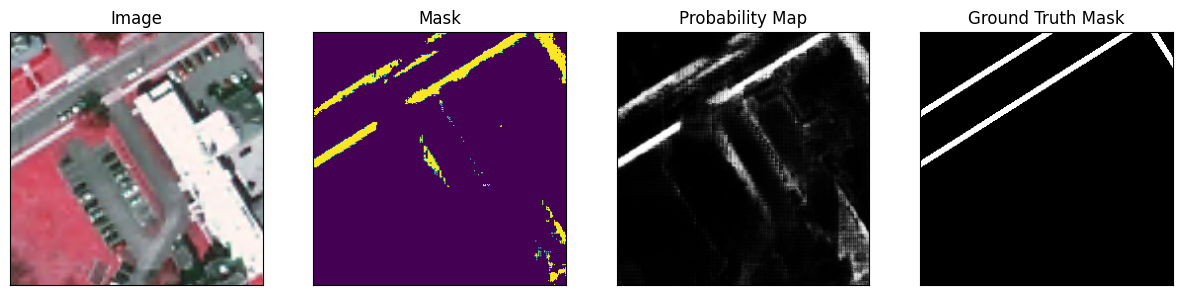

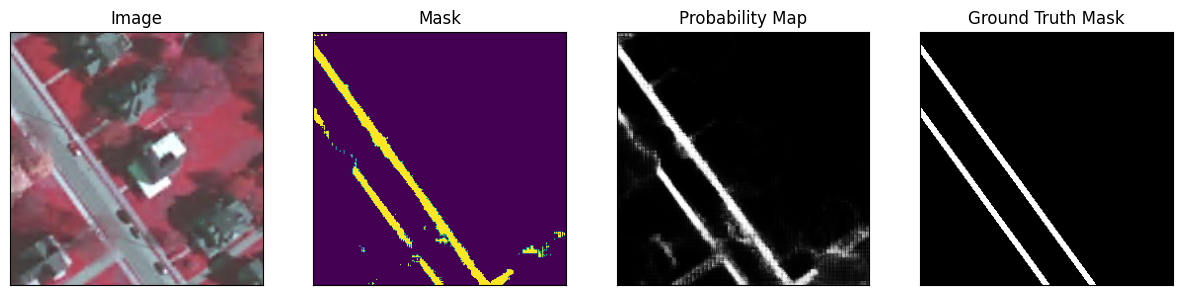

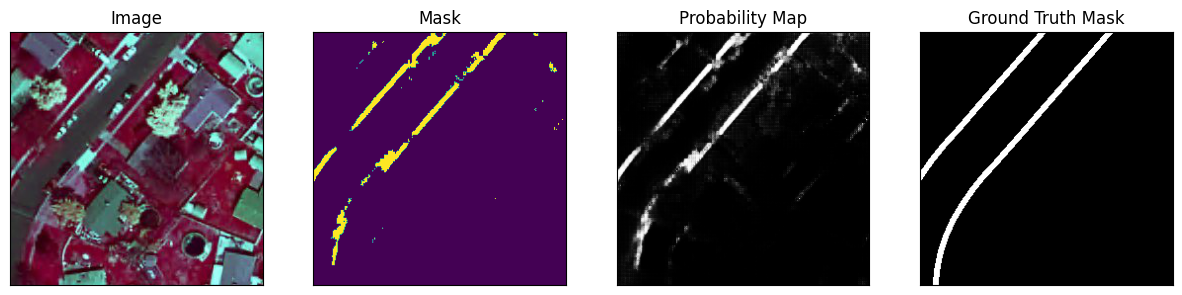

In [74]:
indices = [276, 195, 173, 125, 117, 33, 29, 13, 6, 1]  # put desired images to show in descending order here
# hpc
# indices = [125,117,107,102, 85,71,66, 33, 27, 1]  # put desired images to show in descending order here

# load image from indices
for index, (batch, image) in enumerate(testloader):
    if index != indices[-1]:
        continue
    plot_batch(batch, image)
    plt.show()
    indices.pop()
    if len(indices) == 0:
        break

### Segment trees and combine it with sidewalk masks

In [102]:
# to replace centerline in case the input polygon is 1D (which centerline throws an error)
class CenterlineDummy:
    def __init__(self, polygon):
        self.geometry = MultiLineString([polygon.boundary])
        self._input_geometry = polygon


# known limitations: it merely consider two closest lines geometrically, so
# no noisy base segmentations; no narrow streets and big gaps; and
# you must prompt at the center point of the desired merge section to avoid the second closest line being 
# the sidewalk on the other side of the street
class SidewalkPrompter:
    def __init__(self, input, image, tree_coords, rectangle_width=4):
        self.input = input
        self.image = image
        self.tree_coords = np.array(tree_coords)
        self.rectangle_width = rectangle_width  # rectangle for merging two sections of sidewalks

    # find closest two lines for each of the tree coords
    def _find_closest_two_lines(self, centerlines):
        closest2lines = [[None, None] for _ in self.tree_coords]

        for multiline in centerlines:
            lines = multiline.geometry
            for tree_index, tree in enumerate(self.tree_coords):
                point = shapely.Point(tree[0], tree[1])
                distance = shapely.distance(lines, point)
                filled = False

                for i in range(2):  # replace any None entries first
                    if closest2lines[tree_index][i] is None and not filled:
                        closest2lines[tree_index][i] \
                            = distance, nearest_points(point, lines), multiline._input_geometry
                        filled = True

                for i in range(2):  # replace entry if the distance is lower and is not already on the other entry
                    contesting_line = closest2lines[tree_index][i]
                    if not filled and (contesting_line is None or contesting_line[0] > distance):
                        closest2lines[tree_index][i] \
                            = distance, nearest_points(point, lines), multiline._input_geometry
                        filled = True

        return closest2lines

    # find and plot segmentation masks with or without tree prompts
    def _find_and_plot_segs(self, axes):
        sidewalk_model.eval()
        # no tree prompting
        with torch.no_grad():
            outputs = sidewalk_model(pixel_values=self.input["pixel_values"].to(device),
                                     input_boxes=self.input["input_boxes"].to(device),
                                     multimask_output=True)
        seg_prob = torch.sigmoid(outputs.pred_masks.squeeze())
        seg_prob = seg_prob.cpu().numpy().transpose(1, 2, 0)
        seg_prob = cv2.cvtColor(seg_prob, cv2.COLOR_RGB2GRAY)
        seg = (seg_prob > 0.5).astype(np.uint8)

        # with tree prompting
        with torch.no_grad():
            outputs_w_tree_prompts = sidewalk_model(pixel_values=batch["pixel_values"].to(device),
                                                    point_coords=np.array(self.tree_coords),
                                                    point_labels=np.array([1]),
                                                    input_boxes=self.input["input_boxes"].to(device),
                                                    multimask_output=True)
        tree_seg_prob = torch.sigmoid(outputs_w_tree_prompts.pred_masks.squeeze())
        tree_seg_prob = tree_seg_prob.cpu().numpy().transpose(1, 2, 0)
        tree_seg_prob = cv2.cvtColor(tree_seg_prob, cv2.COLOR_RGB2GRAY)
        tree_seg = (tree_seg_prob > 0.5).astype(np.uint8)

        axes[0, 0].imshow(self.image)
        axes[0, 0].set_title("Image")

        axes[0, 0].imshow(np.squeeze(self.input["ground_truth_mask"]), cmap='gray')
        axes[0, 0].set_title("Ground Truth Mask")

        axes[0, 1].imshow(seg.astype(float))
        axes[0, 1].set_title("Initial Mask")

        axes[0, 2].imshow(tree_seg.astype(float))
        axes[0, 2].set_title("Mask with tree prompts")
        axes[0, 2].scatter(self.tree_coords[:, 0], self.tree_coords[:, 1], marker="*", s=100)

        return seg, tree_seg

    # find and plot rectangles that merge the two closest sidewalk polygons to a tree coord
    def _find_and_plot_merge_rectangles(self, ax, closest2lines):
        merge_rectangles = []
        for [[_, points1, polygon1], [_, points2, polygon2]] in closest2lines:
            gdf = gpd.GeoSeries(polygon1)
            gdf.plot(ax=ax, color=np.random.rand(3, ))

            gdf = gpd.GeoSeries(polygon2)
            gdf.plot(ax=ax, color=np.random.rand(3, ))

            merge_lines = [LineString([points1[0], points1[1]]), LineString([points2[0], points2[1]])]

            # draw rectangles using merge lines
            for line in merge_lines:
                rect = Polygon([*line.parallel_offset(self.rectangle_width / 2, 'left').coords,
                                *line.parallel_offset(self.rectangle_width / 2,
                                                      'right').coords]).minimum_rotated_rectangle
                merge_rectangles.append(rect)
                gdf = gpd.GeoSeries(rect)
                gdf.plot(ax=ax, color=np.random.rand(3, ))
        return merge_rectangles

    # prompt the model and plot the results
    def prompt_and_plot(self):
        fig, axes = plt.subplots(2, 3, figsize=(15, 15))

        seg, tree_seg = self._find_and_plot_segs(axes)

        # find polygons in tree seg mask
        contours, _ = cv2.findContours(tree_seg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # turn them into Polygon object and filter out insignificant ones
        polygons = [Polygon(contour.squeeze().tolist()) for contour in list(contours) if contour.shape[0] > 10]
        polygons = [polygon for polygon in polygons if polygon.area > 20]
        # find centerline. if the polygon is a line, simply output the boundary using dummy
        centerlines = [Centerline(polygon) if polygon.envelope.area > 0 else CenterlineDummy(polygon) for polygon in
                       polygons]
        closest2lines = self._find_closest_two_lines(centerlines)

        axes[1, 0].set_title("Center lines")
        for multiline in centerlines:
            lines = multiline.geometry.geoms
            gdf = gpd.GeoSeries([line for line in lines])
            gdf.plot(ax=axes[1, 0], color=np.random.rand(3, ))
        axes[1, 0].invert_yaxis()

        axes[1, 1].set_title("Merge polygons closest to point")
        axes[1, 1].invert_yaxis()

        merge_rectangles = self._find_and_plot_merge_rectangles(axes[1, 1], closest2lines)

        axes[1, 2].imshow(self.image)
        axes[1, 2].set_title("Final masks overlayed on image")
        # add merge rectangles to tree seg mask, show these rectangle as different masks
        merge_rectangles_mask = rasterio.features.rasterize(merge_rectangles, out_shape=tree_seg.shape)
        self._show_mask(tree_seg, axes[1, 2])
        self._show_mask(merge_rectangles_mask, axes[1, 2], red_mask=True)

        return merge_rectangles

    # display masks on an image. modified from segment anything github repo
    def _show_mask(self, mask, ax, red_mask=False):
        if red_mask:
            color = np.array([1, 0, 0, 0.6])
        else:
            color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)


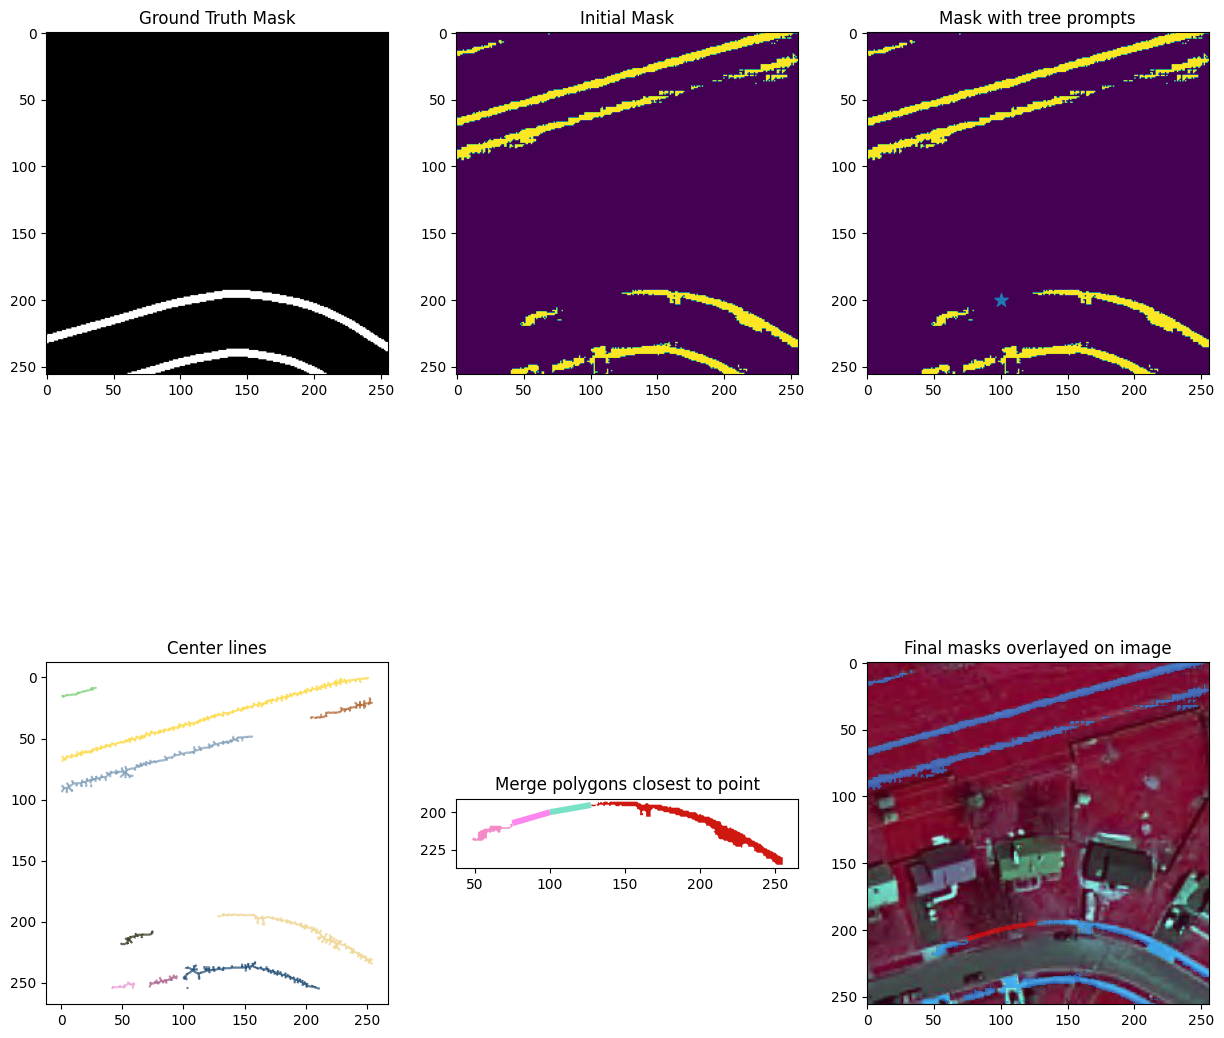

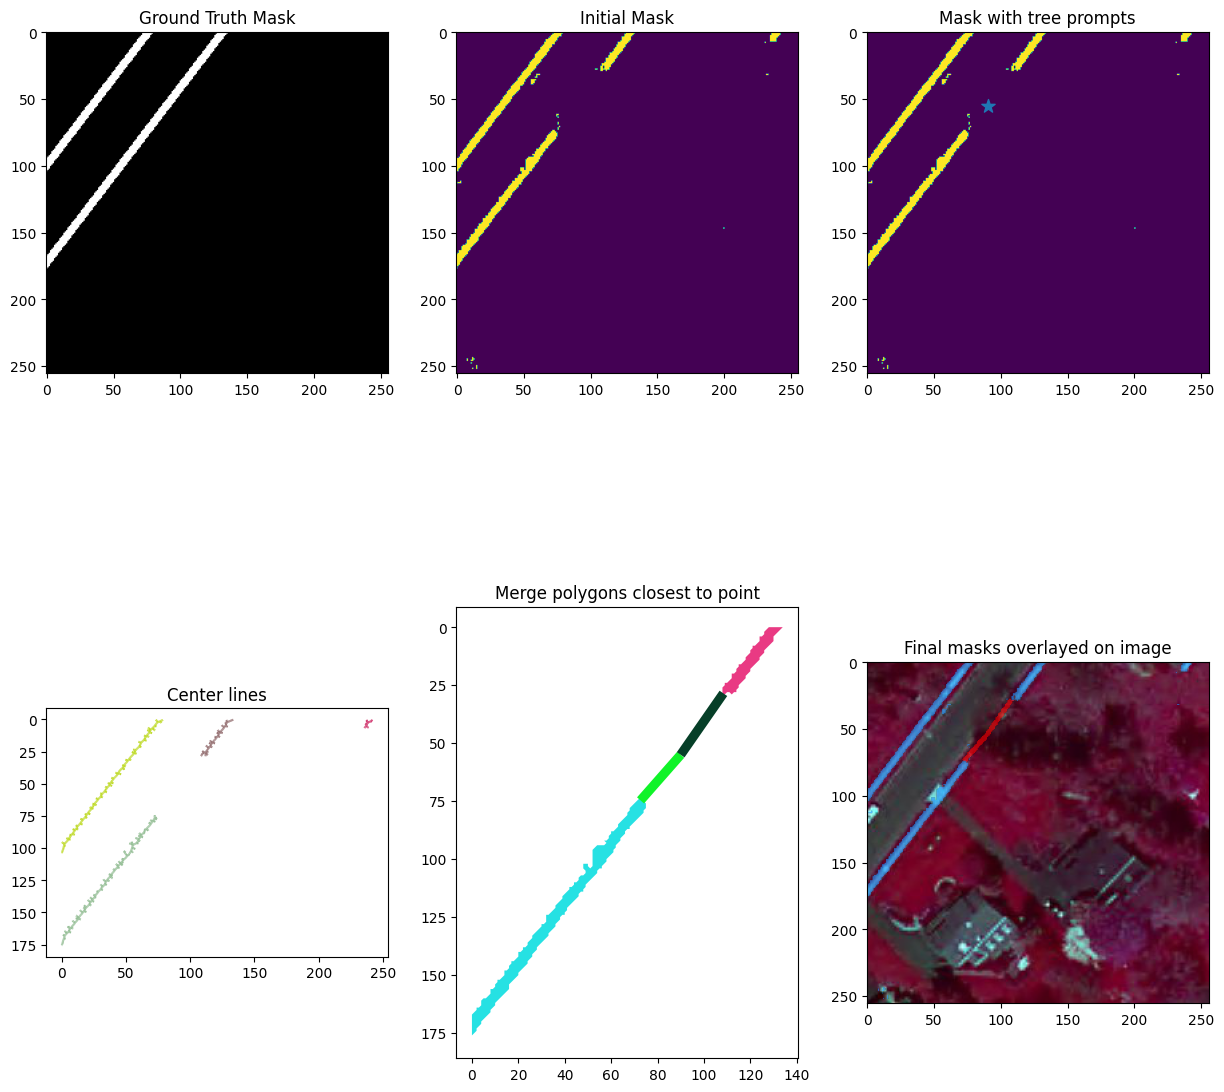

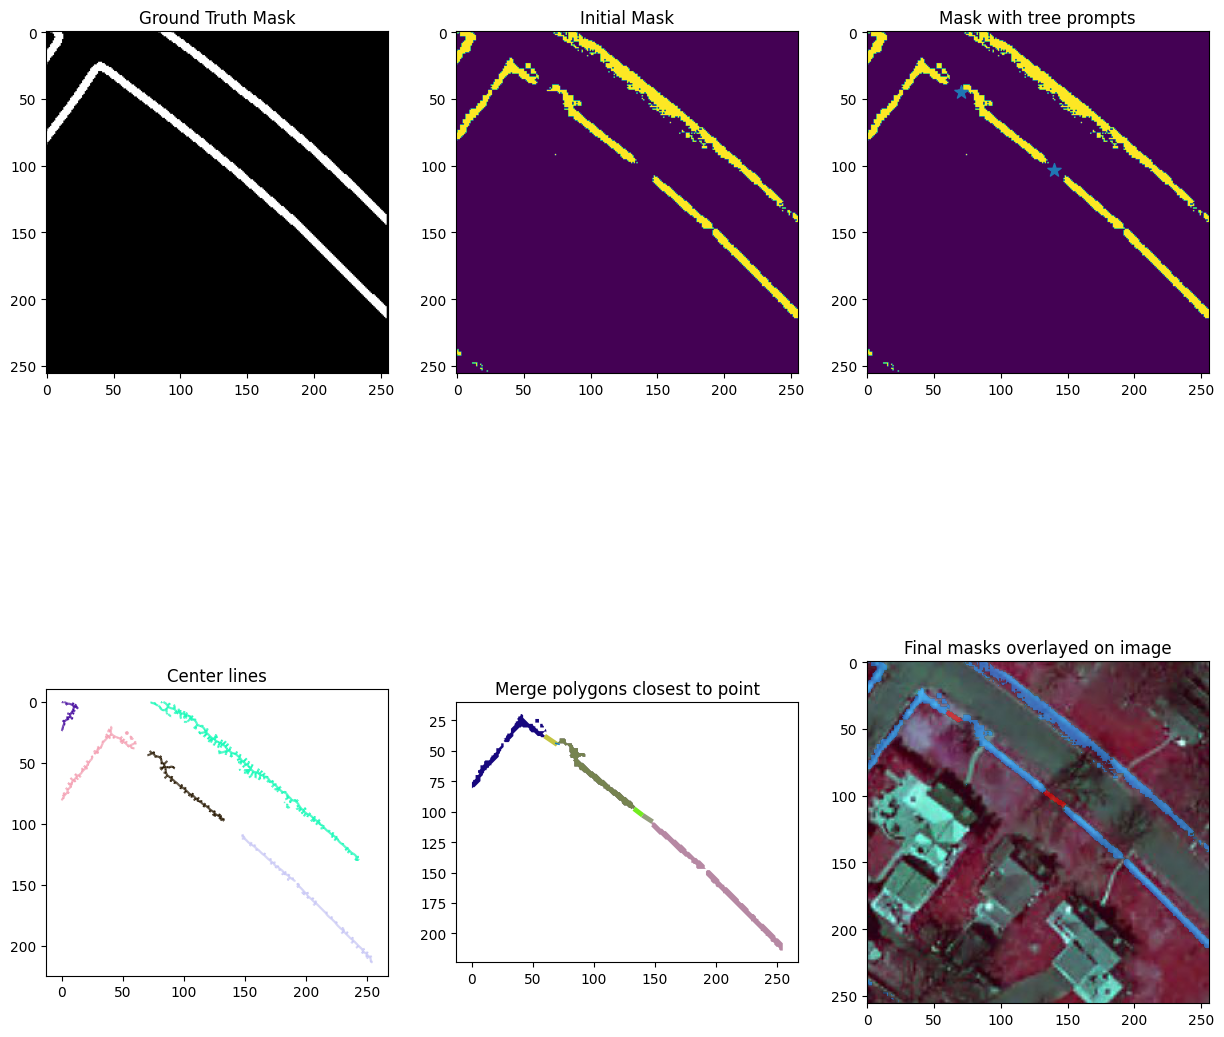

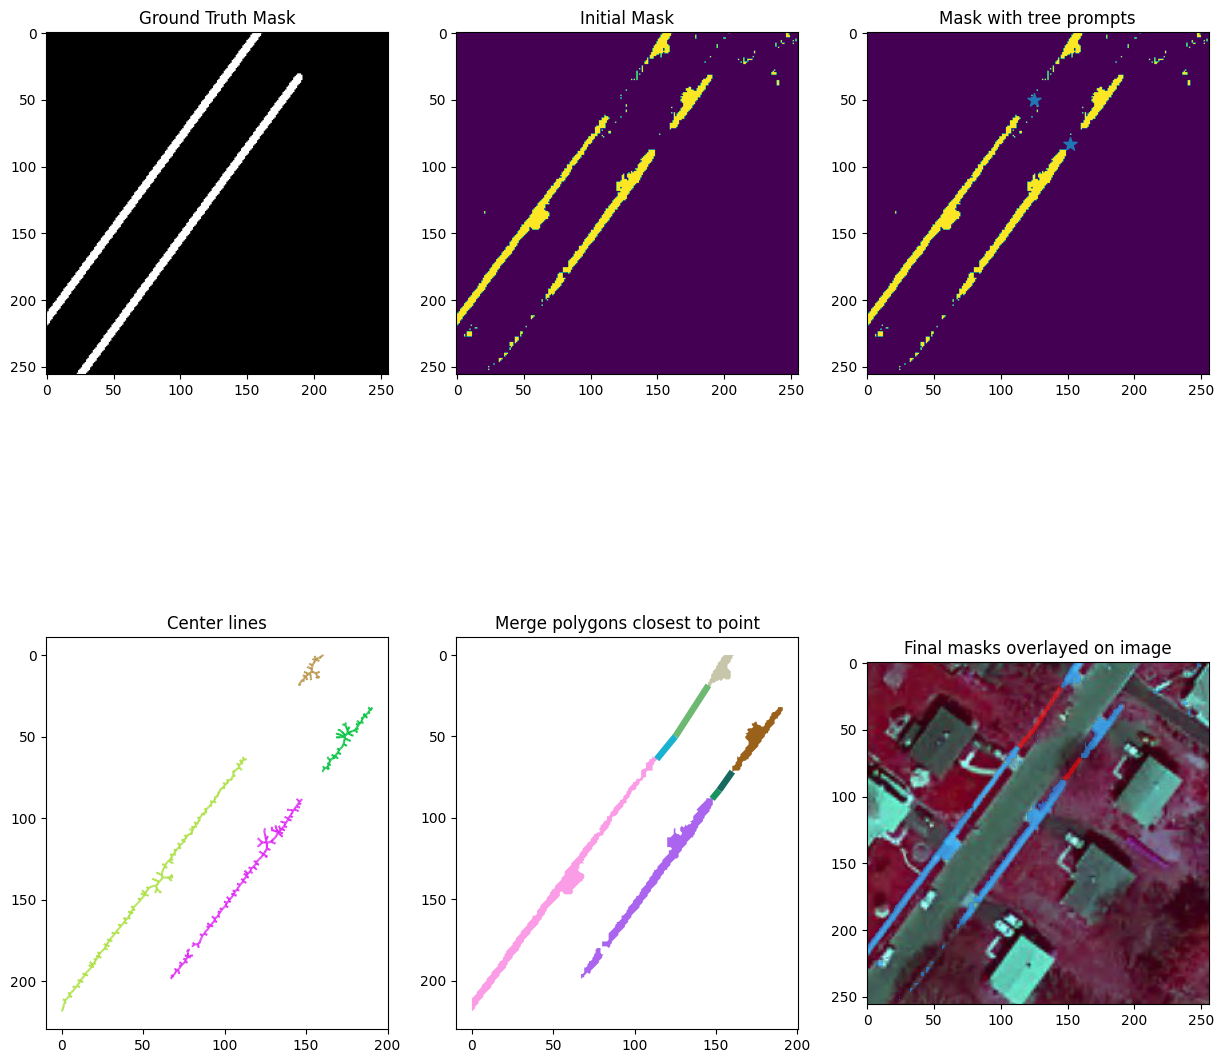

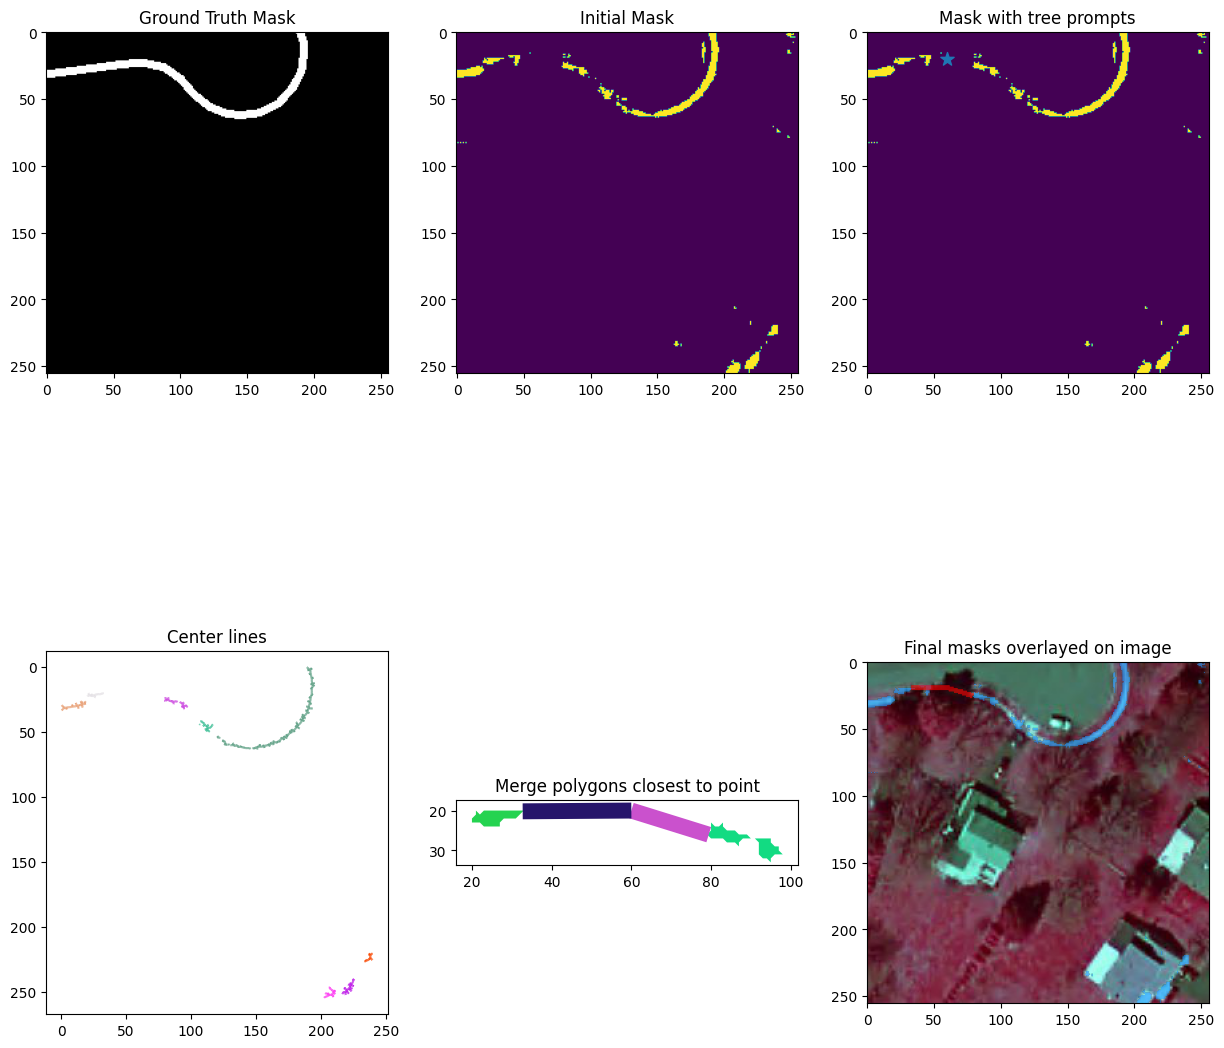

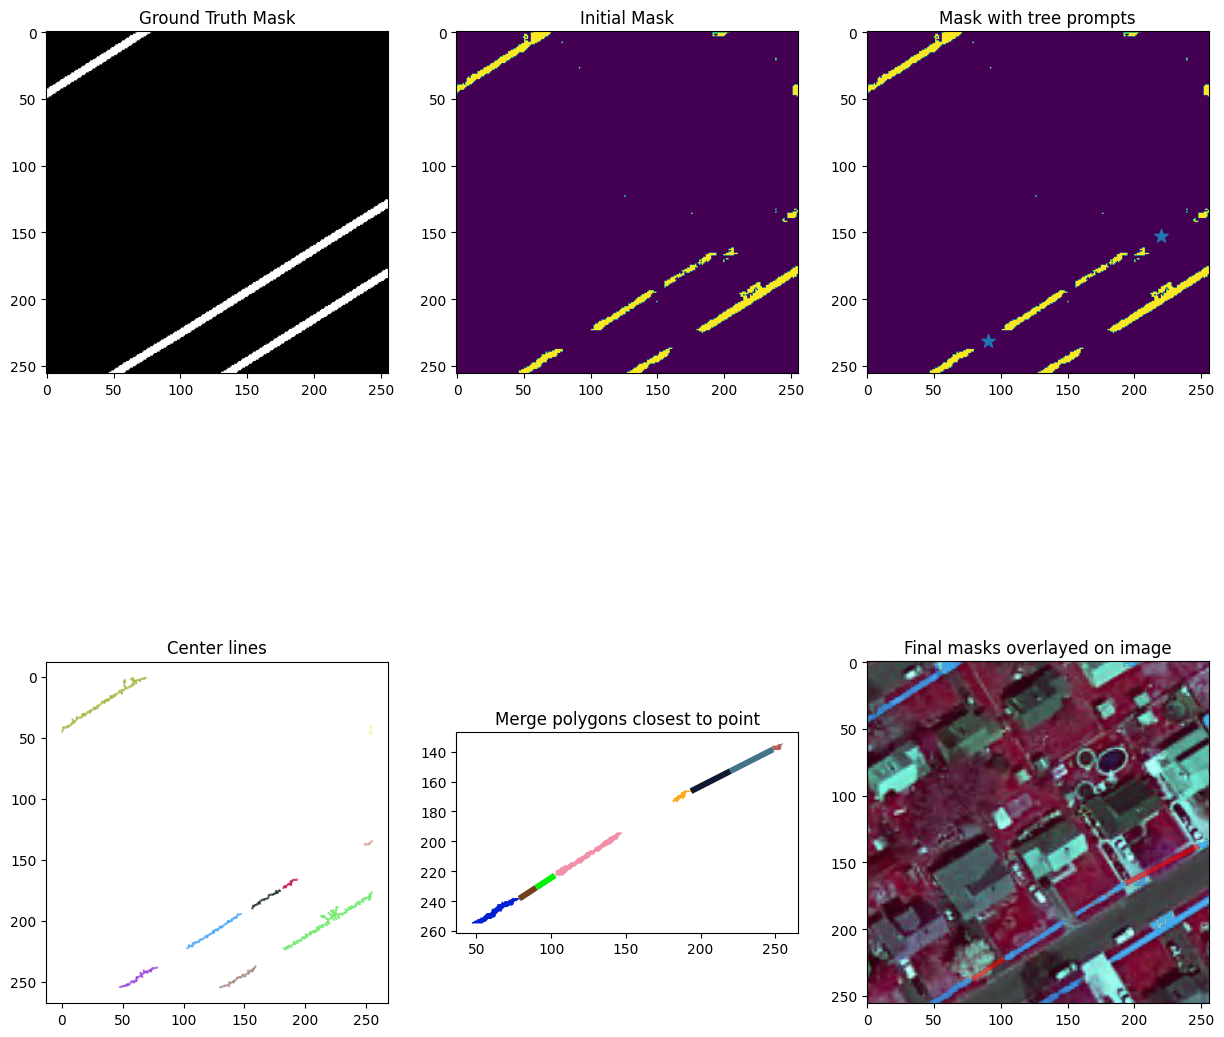

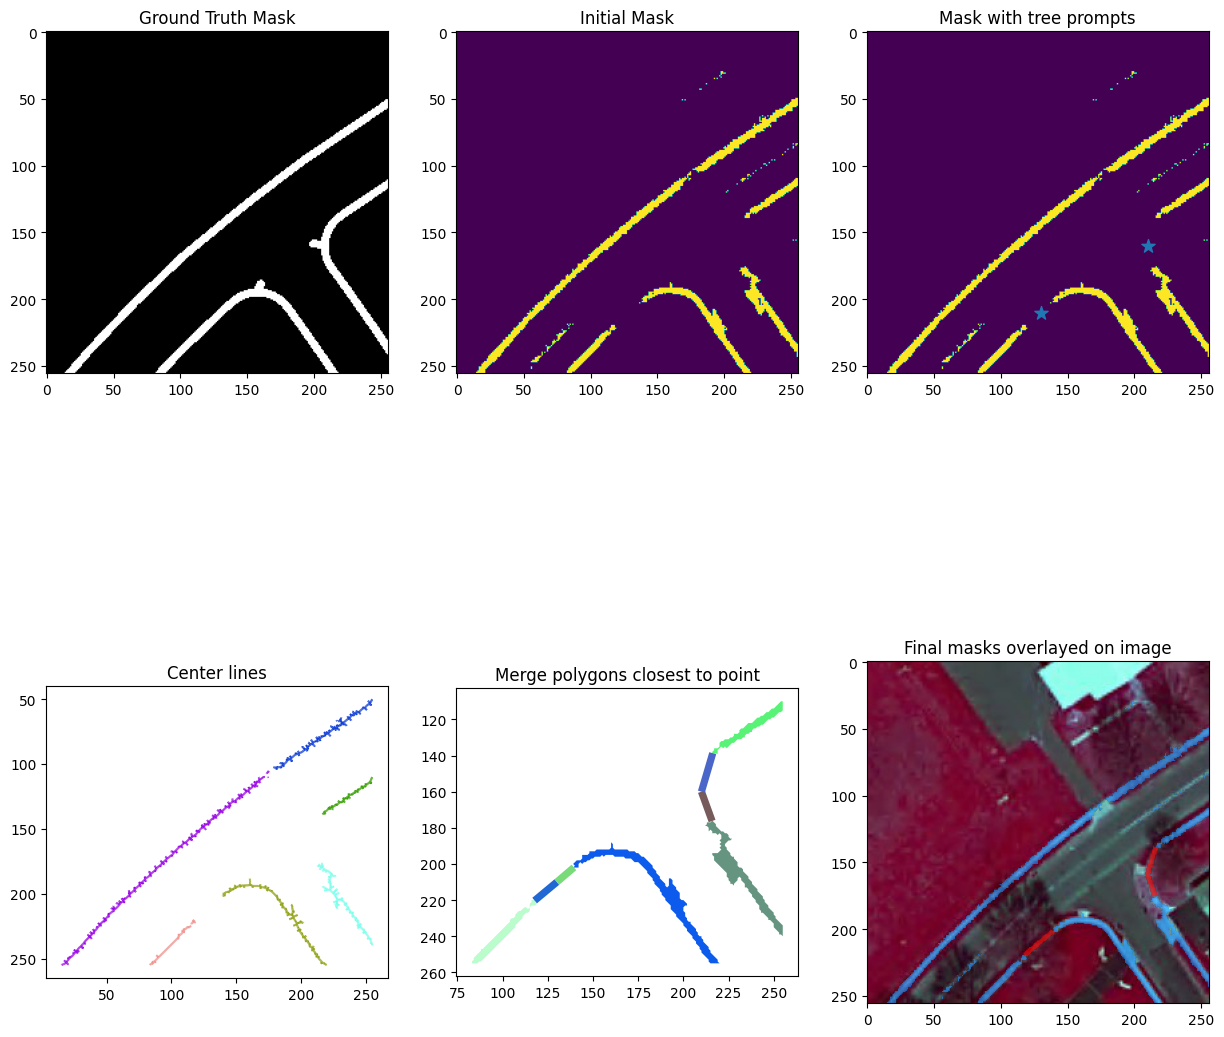

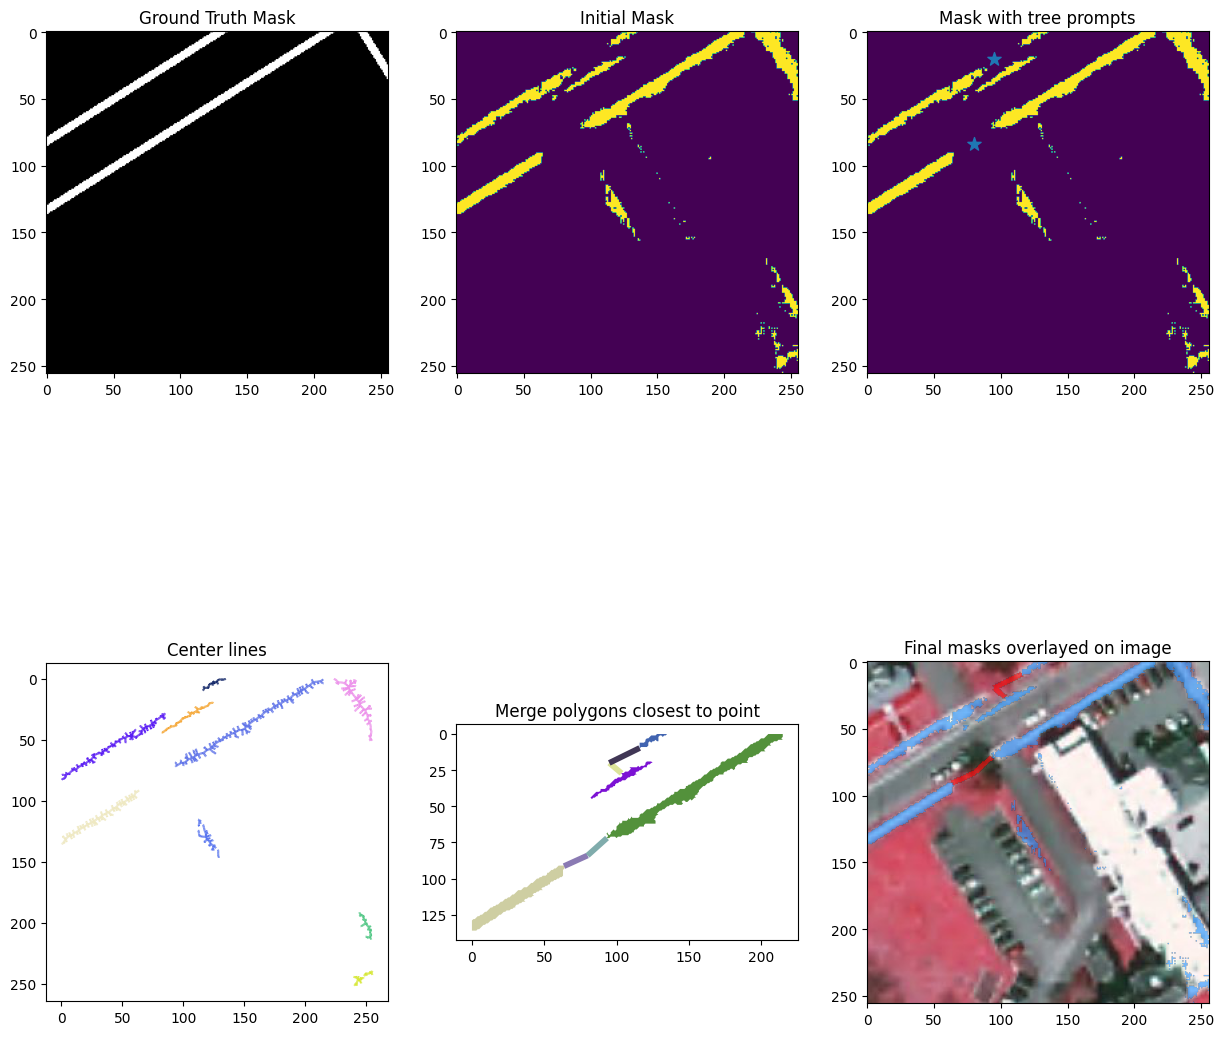

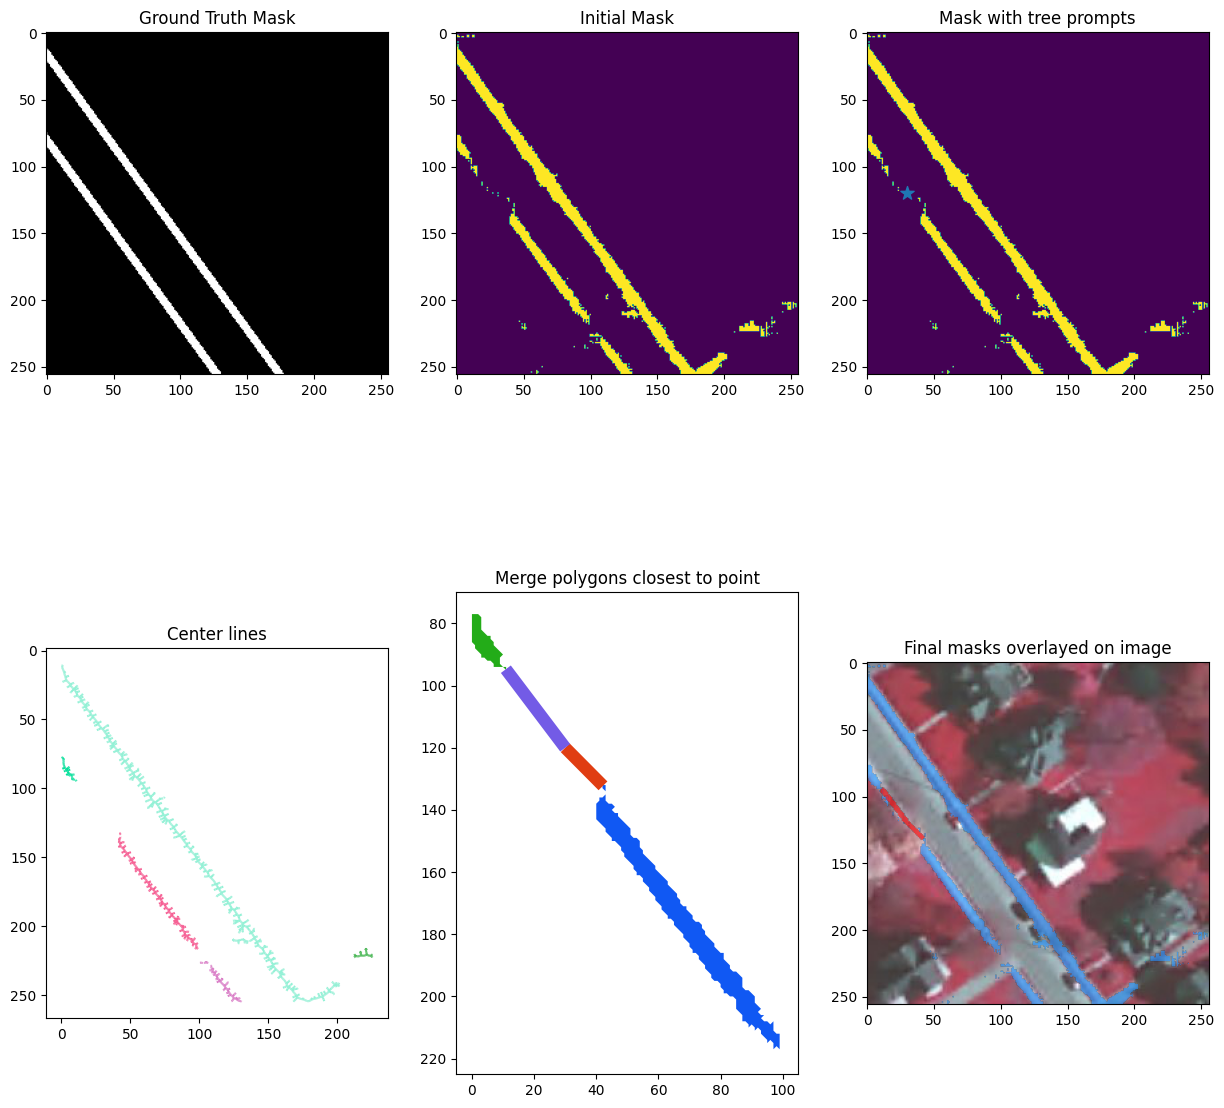

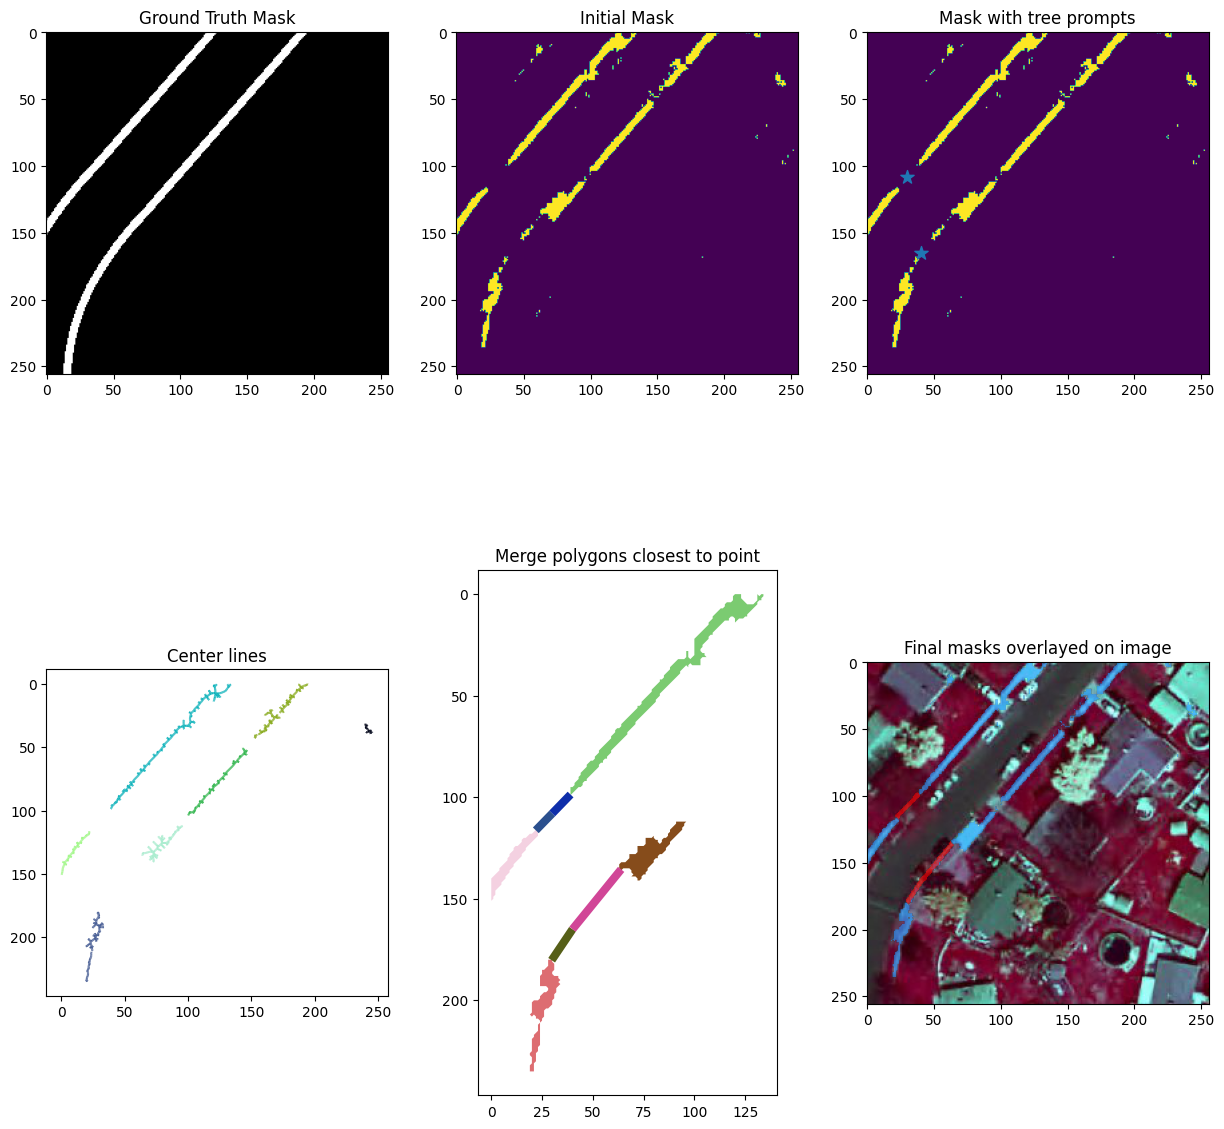

In [103]:
indices = [276, 195, 173, 125, 117, 33, 29, 13, 6, 1]  # put desired images to show in descending order here

# put prompt points that correspond to the indices above.
# note: prompts only work in a low noise environment after initial segmentation. try to place prompt at the  
# center point of the desired merge line
prompts = [
    [[30, 108], [40, 165]], [[30, 120]], [[80, 84], [95, 20]], [[130, 210], [210, 160]],
    [[90, 231], [220, 153]], [[60, 20]], [[125, 50], [152, 83]], [[70, 45], [140, 103]], [[90, 55]], [[100, 200]]
]
testset = SAMDataset(test_images_path, test_label_path, processor)
testloader = DataLoader(testset, batch_size=1)
device = 'cuda'

# load image from indices
for index, (batch, image) in enumerate(testloader):
    if index != indices[-1]:
        continue
    image = image.numpy().squeeze()

    # the following is useful when testing out prompts
    # plt.imshow(image)
    # plt.xticks(np.arange(256, step=20))
    # plt.yticks(np.arange(256, step=10))
    # plt.grid(color='r', linestyle='-', linewidth=1)
    # plt.show()

    prompter = SidewalkPrompter(batch, image, prompts[-1])
    prompter.prompt_and_plot()
    plt.show()
    prompts.pop()
    indices.pop()
    if len(indices) == 0:
        break